In [1]:
import numpy as np
import cv2
import os
# from PIL import Image
import matplotlib.pyplot as plt
import csv

Турецкие строчные буквы - abcçdefgğhiijklmnoöprsştüvyz 

In [57]:
input = "./input"
for filename in os.listdir(input):
    if filename.endswith(('.png', '.bmp')):
        image_path = os.path.join(input, filename)
        im = cv2.imread(image_path)
        image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY_INV)
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])

        cropped_image = im[y:y+h, x:x+w]

        cv2.imwrite(input+'/cropped_'+filename, cropped_image)

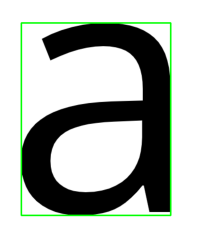

In [51]:
x,y,w,h = cv2.boundingRect(contours[0])
cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(im)
plt.axis('off') 
plt.show()

In [5]:
class FeatureExtractor:
    def __init__(self, output):
        self.output = output
    
    def show(self, im):
        plt.imshow(im)
        plt.axis('off') 
        plt.show()

    def save_features_csv(self,features, name):
        filename = os.path.join(self.output, name+".csv")
        with open(filename, 'w') as f: 
            w = csv.DictWriter(f, features.keys())
            w.writeheader()
            w.writerow(features)

    def save_profiles_hist(self, h_p, v_p, name):
        x = list(range(h_p.size))
        plt.bar(x,h_p,width=1.0)
        filename = os.path.join(self.output, name+"_H_profile"+".png")
        plt.savefig(filename)
        plt.clf()
        x = list(range(v_p.size))
        plt.bar(x,v_p,width=1.0)
        filename = os.path.join(self.output, name+"_V_profile"+".png")
        plt.savefig(filename)
        plt.clf()

    def calc_raw_moment(self,img,x1=0,x2=-1,y1=0,y2=-1,p=0,q=0):
        if y2<0:
            y2=img.shape[0]
        if x2<0:
            x2=img.shape[1]
        rm = 0
        for y in range(y1,y2):
            for x in range(x1,x2):
                rm += x**p * y**q * img[x,y]
        return rm

    def calc_weight(self, img,x1,x2,y1,y2):
        return self.calc_raw_moment(img,x1,x2,y1,y2,0,0)
    
    def calc_rel_weight(self, img,x1,x2,y1,y2):
        h = x2-x1
        w = y2-y1
        return self.calc_raw_moment(img,x1,x2,y1,y2,0,0) / (h*w)
    
    def calc_center(self,img):
        H, W = img.shape[0], img.shape[1]
        weight = self.calc_raw_moment(img,0,H,0,W)
        return [self.calc_raw_moment(img,0,H,0,W,1,0)/weight,
                self.calc_raw_moment(img,0,H,0,W,0,1)/weight]

    def calc_inertia_moment(self,img):
        xc,yc = self.calc_center(img)
        xim = 0
        yim = 0
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                xim += (y - yc) ** 2 * img[x, y]
                yim += (x - xc) ** 2 * img[x, y]
        return [xim,yim]
    
    def calc_rel_inertia_moment(self,img):
        im = self.calc_inertia_moment(img)
        return im / (img.shape[0]**2 * img.shape[1]**2)

    def get_features(self,image, name):
        _, img = cv2.threshold(image, 100, 1, cv2.THRESH_BINARY_INV)
        H, W = img.shape[0], img.shape[1]
        areas = [(H//2) * (W//2),   (H//2)*(W-W//2), 
                 (H-H//2) * (W//2), (H-H//2) * (W-W//2)]
        weights = [self.calc_weight(img, 0, H//2, 0, W//2), 
                   self.calc_weight(img, 0, H//2, W//2, W),
                   self.calc_weight(img, H//2, H, 0, W//2),
                   self.calc_weight(img, H//2, H, W//2, W),]
        weight = self.calc_weight(img, 0, H, 0, W)
        weights_rel = [weights[0]/areas[0],
                       weights[1]/areas[1],
                       weights[2]/areas[2],
                       weights[3]/areas[3]]
        weight_rel = weight / (H*W)
        center = self.calc_center(img)
        center_rel = [(center[0]-1)/(H-1), (center[1]-1)/(W-1)]
        inertia = self.calc_inertia_moment(img)
        inertia_rel = np.divide(inertia, H**2 * W**2)

        H_profile = np.sum(img == 1, axis=1)
        V_profile = np.sum(img == 1, axis=0)

        features = {
            "weight": weight,
            "rel_weight": weight_rel,
            "weights" : weights,
            "rel_weights" : weights_rel,
            "center" : center,
            "center_norm" : center_rel,
            "inertia_hor" : inertia[0],
            "inertia_vert" : inertia[1],
            "inertia_hor_norm" : inertia_rel[0],
            "inertia_vert_norm" : inertia_rel[1],
        }

        self.save_features_csv(features, name)
        self.save_profiles_hist(H_profile,V_profile,name)

        # plt.imshow(image, cmap='gray')
        # plt.plot(center[0], center[1], 'o', markersize=10)
        # plt.axis('off') 
        # plt.show()

In [8]:
im = cv2.imread('./input/,.png', cv2.IMREAD_GRAYSCALE)
agent = FeatureExtractor("./output")
agent.get_features(im, ",") 

<Figure size 432x288 with 0 Axes>

In [7]:
path = "./input"
output = "./output"

agent = FeatureExtractor(output)

for filename in os.listdir(path):
    if filename.endswith(('.png', '.bmp')):
        image_path = os.path.join(path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        agent.get_features(image, filename[:-4])

<Figure size 432x288 with 0 Axes>

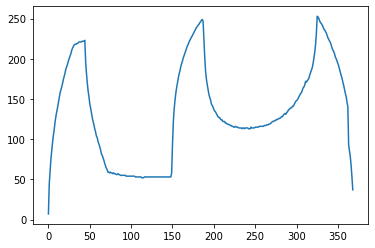

In [183]:
x1 = list(range(vp.size))
plt.plot(x1,vp)

<BarContainer object of 369 artists>

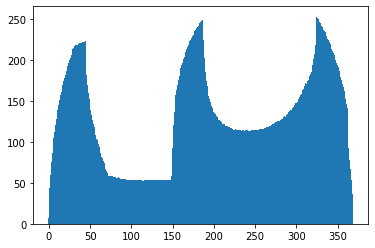

In [188]:
x1 = list(range(vp.size))
width = 1.0
plt.bar(x1,vp,width=width)

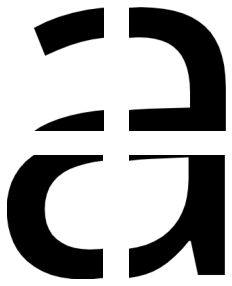

In [102]:
im = cv2.imread('./input/cropped_a.png')

H,W = im.shape[0],im.shape[1]
fig = plt.figure(figsize=(4, 5))
gs = fig.add_gridspec(2, 2) 
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

im1 = im[:H//2,:W//2]
ax1.imshow(im1)
ax1.axis('off') 
im2 = im[:H//2,W//2:W]
ax2.imshow(im2)
ax2.axis('off') 
im3 = im[H//2:H,:W//2]
ax3.imshow(im3)
ax3.axis('off')
im4 = im[H//2:H,W//2:W]
ax4.imshow(im4)
ax4.axis('off')
plt.show()